## Crawl and extract keyword

In [ ]:
import os
import ast
import json
import pickle
import pandas as pd

# from datasets import load_dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer,
    BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


class BERTEncoder(nn.Module):
    def __init__(self, bert_model_name):
        super(BERTEncoder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
        self.bert = BertModel.from_pretrained(bert_model_name)
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # abstract_tokens = [tokenizer.decode(idx) for idx in abstract_tokens]
        # abstracts = " ".join(abstract_tokens)
        # inputs = self.tokenizer(abstracts, return_tensors="pt")
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # inputs = self.tokenizer("Hello world!", return_tensors="pt").to('cuda')
        # output_test = self.bert(**inputs)
        # print(output_test.last_hidden_state)
        return outputs.last_hidden_state[0]

    def one_embed(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output

    def get_output_shape(self):
        return self.bert.config.hidden_size


class FFClassifier(nn.Module):
    # input_shape: bert output shape, num_classes = 3 (BIO)
    def __init__(self, input_shape, hidden_size, num_classes):
        super(FFClassifier, self).__init__()
        self.fc1 = nn.Linear(input_shape, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, token_embeds):
        # print(type(token_embeds))
        x = torch.relu(self.fc1(token_embeds))
        x = self.fc2(x)
        x = self.softmax(x)
        return x


class Phraseformer(nn.Module):
    def __init__(
        self,
        bert_model_name,
        is_train_bert,
        is_graph_embedding,
        len_graph_embedding,
        path_graph_embedding,
    ):
        super(Phraseformer, self).__init__()
        # self.bert_model_name = bert_model_name
        self.bertEmbed = BERTEncoder(bert_model_name)
        self.len_graph_embedding = len_graph_embedding
        if is_train_bert:
            print("Có transfer learning bert")
        if is_graph_embedding:
            print("Có kết hợp graph embedding")
        self.ffclassifier = FFClassifier(
            self.bertEmbed.get_output_shape() + len_graph_embedding, 256, 3
        )

        # load graph_embedding
        with open(path_graph_embedding, "rb") as f:
            self.combined_vectors = pickle.load(f)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, abstract_tokens, input_ids, attention_mask):
        bertEmbedding = self.bertEmbed(input_ids, attention_mask)
        # print("bertEmbedding.shape", bertEmbedding.shape)
        graphEmbedding = torch.tensor(
            [
                (
                    self.combined_vectors[abstract_token]
                    if abstract_token in self.combined_vectors
                    else [0] * self.len_graph_embedding
                )
                for abstract_token in abstract_tokens
            ]
        )
        add_padding = torch.tensor(
            [[-100] * self.len_graph_embedding] * (512 - graphEmbedding.shape[0])
        )
        # print("add_padding.shape", add_padding.shape)
        # print("graphEmbedding.shape", graphEmbedding.shape)
        graphEmbedding_pad = torch.cat((graphEmbedding, add_padding), dim=0).to(
            self.device
        )
        # print("graphEmbedding_pad.shape", graphEmbedding_pad.shape)
        full_embedding = torch.cat((bertEmbedding, graphEmbedding_pad), dim=1).to(
            torch.float32
        )
        # print(full_embedding.dtype)
        labels = self.ffclassifier(full_embedding)
        return labels

    def get_embedding(self, abstract_tokens, input_ids, attention_mask):
        bertEmbedding = self.bertEmbed.one_embed(input_ids, attention_mask)
        return bertEmbedding


# init hyperparameter of model
is_train_bert = True
is_graph_embedding = True
len_graph_embedding = 600
path_graph_embedding = "./combined_vectors_600_th3_1e5_full.pkl"
bert_model_name = "google-bert/bert-base-uncased"
max_length = 512
hidden_size = 256
num_classes = 3
batch_size = 1
num_epochs = 4
learning_rate = 2e-5

tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Phraseformer(bert_model_name, is_train_bert, is_graph_embedding, len_graph_embedding, path_graph_embedding).to(device)

model_path = "./SaveModel/NO_BERT_WVFT_256_155_600.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))


# demo
max_length = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

def tokenizerSplit(text):
  encoding = tokenizer(text, return_tensors='pt')
  decoding = [tokenizer.decode(idx) for idx in encoding['input_ids'][0]]
  return decoding[1:-1]

def extract_keywords_id(abstract_tokens, preds):
    keywords = []
    current_keyword = []
    for token, pred in zip(abstract_tokens, preds):
        if pred == 1:  # Nhãn thể hiện token bắt đầu một keyword
            if current_keyword != []:
                keywords.append(current_keyword)
            current_keyword = [token]  # Token đầu tiên của keyword
        elif pred == 2:  # Nhãn thể hiện token bên trong keyword
            current_keyword.append(token)  # Thêm token vào keyword
    if current_keyword != []:
        keywords.append(current_keyword)
    list_keyword = []
    for one_keyword in keywords:
        decoded_sequence = tokenizer.decode(one_keyword)
        list_keyword.append(decoded_sequence)
    return list_keyword

def find_keyword(abstract):
    # abstract = """A  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a  synapse array through to silicon layout and board design.  The issues surrounding bit  - serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel  development  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and  recall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected  specification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173) nique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms,  using  a  "paging"  technique  to  time  - multiplex  calculations  through  the  synapse  array."""
    abstract_tokens = tokenizerSplit(abstract)
    print(len(abstract_tokens))
    if (len(abstract_tokens)>max_length-2):
        return []
    encoding = tokenizer(abstract, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    # print(len(abstract_tokens))
    # print(input_ids.shape)
    # print(attention_mask.shape)
    outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
    outputs = outputs[1:len(abstract_tokens)+1]
    _, preds = torch.max(outputs, dim=1)
    preds_Id = extract_keywords_id(input_ids[0][1:len(abstract_tokens)+1], preds)
    unique_preds_Id = list(set(preds_Id))
    # print(unique_preds_Id)
    return unique_preds_Id

abstract_demo = "this is my abstract. I want to extract keyword."
print(find_keyword(abstract_demo))
text = input('nhap to end:')

# CUDA Version: 12.2

cuda
Có transfer learning bert
Có kết hợp graph embedding
12


<ipython-input-4-58034efd8fff>:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  graphEmbedding = torch.tensor(


['abstract']
nhap to end:a


In [ ]:
# read file csv được crawl bởi mạnh
df_test = pd.read_csv('./CrawlData/papers_data_new.csv')
# Áp dụng hàm find_keyword cho mỗi hàng của DataFrame và tạo cột Keywords
df_test['Keywords'] = df_test.apply(lambda x: find_keyword(x['Abstract']), axis=1)
# Lưu DataFrame df_test thành một file CSV mới
df_test.to_csv('./CrawlData/papers_data_done_new.csv', index=False)
df_old = pd.read_csv('./CrawlData/papers_data_done.csv')
result = pd.concat([df_old, df_test], axis=0)
result.to_csv('./CrawlData/papers_data_done.csv', index=False)

142
110
131
283
314


In [ ]:
# keyword_col = df_test[['Keywords']]
import ast
# Tạo một tập hợp để chứa tất cả các từ khóa
all_keywords = set()

# Lặp qua mỗi hàng dữ liệu trong cột 'Keywords'
for keywords_list in df_test['Keywords']:
    print(keywords_list)
    # arr = ast.literal_eval(keywords_list)
    # Chuyển đổi mảng từ khóa thành tập hợp và thêm vào tập hợp chứa tất cả các từ khóa
    all_keywords.update(set(keywords_list))

all_keywords_list = list(all_keywords)
print(all_keywords_list)

['synapse array', 'recall', 'digital arithmetic', 'board design', 'parallel', 'vlsi neural network', 'digital neural network', 'bit serial network', 'bit serial', 'synapses network time', 'silicon layout', 'bit', 'analog', 'learning', 'ne', 'serial board', 'bit serial computation', 'hybrid', 'paging technique multiple']
['local learning rule connectivity', 'ne', 'switching theory', 'synapses', 'boolean functions', 'nand gates', 'network', 'neural network', 'entropy', 'connectivity']
['ne input output relations statesons', 'learning rule', 'american institute of', 'associative memoryization neurons', 'information capacityization sum', 'outer products', 'hopfield neural network', 'physics', 'quantization rules']
['neural net', 'quali', 'symbol processing', 'geometrical', 'neural net functionspropagation neural net network', '##tative reasoning', 'signal processing applicationspolation', 'floating point numbers', 'neural', 'methds', 'neural network', 'neural networks', 'interpolation', 'f

In [ ]:
len(all_keywords_list)

88

In [ ]:
def one_embed(abstract):
    # abstract = """A  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a  synapse array through to silicon layout and board design.  The issues surrounding bit  - serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel  development  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and  recall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected  specification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173) nique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms,  using  a  "paging"  technique  to  time  - multiplex  calculations  through  the  synapse  array."""
    abstract_tokens = tokenizerSplit(abstract)
    # print(len(abstract_tokens))
    if (len(abstract_tokens)>max_length-2):
        return []
    encoding = tokenizer(abstract, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    # print(len(abstract_tokens))
    # print(input_ids.shape)
    # print(attention_mask.shape)
    outputs = model.get_embedding(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
    return outputs

In [ ]:
one_emb_dict = {}
for i in range(0, len(all_keywords_list), 1000):
  if (i+1000<len(all_keywords_list)):
    all_keywords_list_split = all_keywords_list[i:i+1000]
  else:
    all_keywords_list_split = all_keywords_list[i:]
  # can remove keyword here
  one_emb_dict_split = list(map(one_embed, all_keywords_list_split))
  for j in range(len(one_emb_dict_split)):
    one_emb_dict[all_keywords_list_split[j]] = one_emb_dict_split[j]
  print(i)

print(len(one_emb_dict))

0
88


In [ ]:
# Giả sử từ điển có cấu trúc như {'key': tensor} và tensor có thể chuyển đổi thành list
# Chuyển đổi dictionary thành danh sách để lưu vào file CSV
import csv
import torch
csv_data = []

for key, value in one_emb_dict.items():
    # Nếu giá trị là tensor, chuyển đổi nó thành list
    if isinstance(value, torch.Tensor):
        value = value.tolist()
    # Thêm key và value vào danh sách csv_data
    csv_data.append([key] + value)

# Lưu vào file .csv
with open("output_new.csv", "w", newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Ghi tiêu đề nếu cần (ví dụ: ['Key', 'Value1', 'Value2', ...])
    # csvwriter.writerow(['Key'] + ['Value' + str(i) for i in range(len(csv_data[0]) - 1)])
    # Ghi dữ liệu
    csvwriter.writerows(csv_data)

In [ ]:
import csv

# Hàm để đọc dữ liệu từ file CSV vào dictionary
def read_csv_to_dict(file_path):
    data_dict = {}
    with open(file_path, mode='r') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            key = row[0]
            values = row[1:]
            data_dict[key] = values
    return data_dict

# Đọc dữ liệu từ hai file CSV
new_data = read_csv_to_dict('output_new.csv')
old_data = read_csv_to_dict('output.csv')

# Hợp nhất dữ liệu, ưu tiên dữ liệu từ file mới
merged_data = old_data.copy()
merged_data.update(new_data)

# Viết dữ liệu hợp nhất ra file CSV mới
with open('merged_output.csv', mode='w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for key, values in merged_data.items():
        csvwriter.writerow([key] + values)

Training:
1. Run Import Lib
2. Run Load and Preprocess Data

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


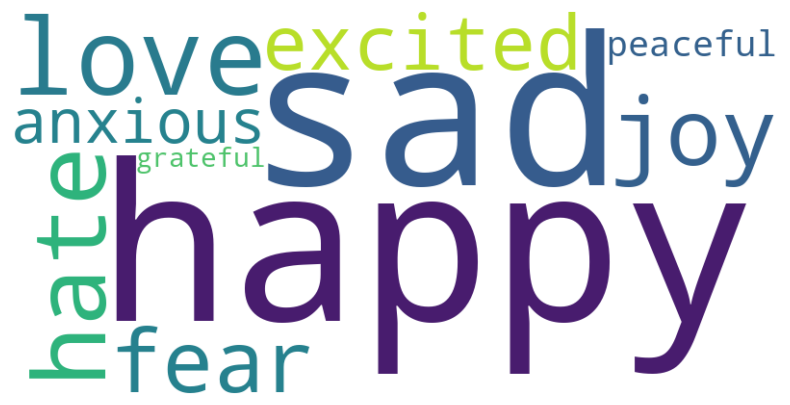

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tần suất từ
word_frequencies = {
    'happy': 100,
    'sad': 90,
    'love': 80,
    'hate': 70,
    'joy': 60,
    'fear': 50,
    'excited': 40,
    'anxious': 30,
    'peaceful': 20,
    'grateful': 10
    # Thêm các từ và tần suất của chúng ở đây
}


# Tạo đám mây từ
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Hiển thị đám mây từ
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


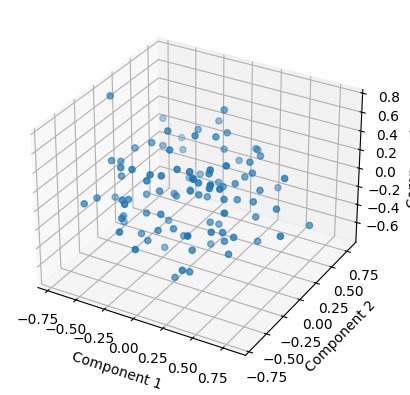

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dữ liệu đầu vào - mỗi từ có vector đặc trưng là 10 phần tử
word_vectors = np.random.rand(100, 10)  # Đây là một ví dụ, bạn cần thay thế bằng dữ liệu thực tế của bạn

# Áp dụng PCA để giảm chiều thành 3 phần tử
pca = PCA(n_components=3)
word_vectors_reduced = pca.fit_transform(word_vectors)

# Trực quan hoá dạng 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Lấy các thành phần riêng lẻ của word_vectors_reduced để truyền vào scatter
x = word_vectors_reduced[:, 0]
y = word_vectors_reduced[:, 1]
z = word_vectors_reduced[:, 2]

# Trực quan hoá dạng 3D
ax.scatter(x, y, z)

# Đặt nhãn cho các trục
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Hiển thị biểu đồ
plt.show()


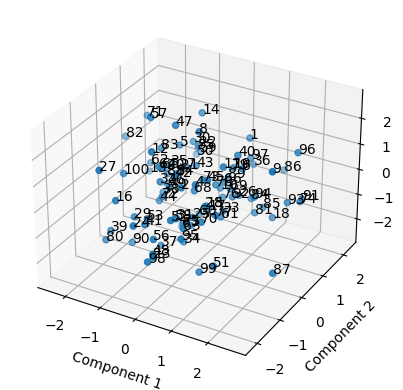

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dữ liệu đầu vào - mỗi từ có vector đặc trưng là 10 phần tử
word_vectors = np.random.rand(100, 768)  # Đây là một ví dụ, bạn cần thay thế bằng dữ liệu thực tế của bạn

# Áp dụng PCA để giảm chiều thành 3 phần tử
pca = PCA(n_components=3)
word_vectors_reduced = pca.fit_transform(word_vectors)

# Tạo một danh sách các nhãn từ 1 đến 100
labels = [str(i) for i in range(1, 101)]

# Trực quan hoá dạng 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Lấy các thành phần riêng lẻ của word_vectors_reduced để truyền vào scatter
x = word_vectors_reduced[:, 0]
y = word_vectors_reduced[:, 1]
z = word_vectors_reduced[:, 2]

# Trực quan hoá dữ liệu 3D
scatter = ax.scatter(x, y, z)

# Đặt nhãn cho từng điểm
for i, txt in enumerate(labels):
    ax.text(x[i], y[i], z[i], txt)

# Đặt nhãn cho các trục
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Hiển thị biểu đồ
plt.show()


## **Import Lib**



In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

In [2]:
%%capture
!pip install datasets

In [3]:
import os
import ast
import json
import pickle
import pandas as pd
from datasets import load_dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir("/content/drive/MyDrive/2_PBL7/")

## **Init**

In [ ]:
dataset_names = ['inspec', 'se-2010', 'se-2017', 'kp20k']

## **Load Data**

- input: abstract
- label: danh sách các keyword

Nguồn data:
- Inspec: https://huggingface.co/datasets/midas/inspec?row=0
- SE-2010: https://huggingface.co/datasets/taln-ls2n/semeval-2010-pre?row=0
- SE-2017: https://huggingface.co/datasets/midas/semeval2017

Hoặc sử dụng kp20k: gồm 530809 rows dữ liệu

### KP20K

In [ ]:
# !unzip "./Phraserformer/data.zip" -d "./Phraserformer"

In [ ]:
# Đường dẫn tới thư mục chứa các file JSON
folder_path = "./Phraserformer/data/dataset/kp20k"

# Khởi tạo một danh sách để lưu trữ dữ liệu từ các file JSON
data_list = []

# Lặp qua tất cả các file trong thư mục
for filename in os.listdir(folder_path):
    # Kiểm tra nếu file có đuôi là ".json"
    if filename.endswith(".json"):
        # Đường dẫn đến file JSON
        file_path = os.path.join(folder_path, filename)
        # Mở file và load nội dung
        with open(file_path, "r") as file:
            # Thêm dữ liệu từ file vào danh sách
            data_list.extend([json.loads(line) for line in file])

In [ ]:
print(len(data_list))

In [ ]:
print(data_list[0:10])

In [ ]:
# Creating DataFrame from list of dictionaries
kp20k_df = pd.DataFrame(data_list)

In [ ]:
kp20k_df['keyword'] = kp20k_df['keyword'].apply(lambda x: x.split(";"))

In [ ]:
# Displaying the DataFrame
kp20k_df.head(5)

### Inspec

In [ ]:
inspec_ds = load_dataset("midas/inspec")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for midas/inspec contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/midas/inspec
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(

Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
print(inspec_ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'doc_bio_tags'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'document', 'doc_bio_tags'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'document', 'doc_bio_tags'],
        num_rows: 500
    })
})


In [ ]:
train_inspec_df = pd.DataFrame(inspec_ds['train'])
validation_inspec_df = pd.DataFrame(inspec_ds['validation'])
test_inspec_df = pd.DataFrame(inspec_ds['test'])

In [ ]:
all_inspec_df = pd.concat([train_inspec_df, validation_inspec_df, test_inspec_df], ignore_index=True)

In [ ]:
print(all_inspec_df)

        id                                           document  \
0     1001  [A, conflict, between, language, and, atomisti...   
1     1002  [Selective, representing, and, world-making, W...   
2     1000  [Does, classicism, explain, universality, ?, A...   
3      100  [Separate, accounts, go, mainstream, -LSB-, in...   
4     1012  [Evolving, receptive-field, controllers, for, ...   
...    ...                                                ...   
1995   402  [Fast, frequency, acquisition, phase-frequency...   
1996   392  [Time-varying, properties, of, renal, autoregu...   
1997   384  [Brightness-independent, start-up, routine, fo...   
1998    37  [Design, PID, controllers, for, desired, time-...   
1999   411  [CAD/CAE, software, aids, converter, design, -...   

                                           doc_bio_tags  
0     [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
1     [B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
2     [O, B, O, B, O, O, O, O, O, B, I, I, I,

In [ ]:
def keyword_list(x):
  keywords = set()
  i = 0
  while i<len(x['doc_bio_tags']):
    if x['doc_bio_tags'][i]=='B':
      keyword = [x['document'][i]]
      while (i+1<len(x['doc_bio_tags']) and x['doc_bio_tags'][i+1]=='I'):
        keyword.append(x['document'][i+1])
        i+=1
      keyword = ' '.join(keyword)
      keywords.add(keyword)
    i+=1
  return list(keywords)
keyword_list(all_inspec_df.loc[0])

['cognitive states',
 'beliefs',
 'philosophy of mind',
 'Content Atomism',
 'Language of Thought',
 'desires',
 'LOT',
 'IBS']

In [ ]:
# Tạo dataframe mới
inspec_df = pd.DataFrame()

# Cột abstract là ghép các phần tử trong document thành chuỗi
inspec_df['abstract'] = all_inspec_df['document'].apply(' '.join)

# Cột keyword lấy các từ có doc_bio_tags = 'B'
inspec_df['keyword'] = all_inspec_df.apply(lambda x: keyword_list(x), axis=1)

In [ ]:
print(inspec_df.iloc[0]['abstract'])
print(inspec_df.iloc[0]['keyword'])

A conflict between language and atomistic information Fred Dretske and Jerry Fodor are responsible for popularizing three well-known theses in contemporary philosophy of mind : the thesis of Information-Based Semantics -LRB- IBS -RRB- , the thesis of Content Atomism -LRB- Atomism -RRB- and the thesis of the Language of Thought -LRB- LOT -RRB- . LOT concerns the semantically relevant structure of representations involved in cognitive states such as beliefs and desires . It maintains that all such representations must have syntactic structures mirroring the structure of their contents . IBS is a thesis about the nature of the relations that connect cognitive representations and their parts to their contents -LRB- semantic relations -RRB- . It holds that these relations supervene solely on relations of the kind that support information content , perhaps with some help from logical principles of combination . Atomism is a thesis about the nature of the content of simple symbols . It holds 

In [ ]:
inspec_df.head(5)

,abstract,keyword
0,A conflict between language and atomistic info...,"[cognitive states, beliefs, philosophy of mind..."
1,Selective representing and world-making We dis...,"[mental representations, selective representin..."
2,Does classicism explain universality ? Argumen...,"[classical symbol systems, classical component..."
3,Separate accounts go mainstream -LSB- investme...,"[independent money managers, investment]"
4,Evolving receptive-field controllers for mobil...,"[simple Braitenberg vehicles, nonlinear intera..."


### SE-2010

In [ ]:
se2010_ds = load_dataset("taln-ls2n/semeval-2010-pre")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for taln-ls2n/semeval-2010-pre contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/taln-ls2n/semeval-2010-pre
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
print(se2010_ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'abstract', 'keyphrases', 'prmu', 'lvl-1', 'lvl-2', 'lvl-3', 'lvl-4'],
        num_rows: 144
    })
    test: Dataset({
        features: ['id', 'title', 'abstract', 'keyphrases', 'prmu', 'lvl-1', 'lvl-2', 'lvl-3', 'lvl-4'],
        num_rows: 100
    })
})


In [ ]:
train_se2010_df = pd.DataFrame(se2010_ds['train'])
test_se2010_df = pd.DataFrame(se2010_ds['test'])

In [ ]:
all_se2010_df = pd.concat([train_se2010_df, test_se2010_df], ignore_index=True)

In [ ]:
all_se2010_df.head(5)

,id,title,abstract,keyphrases,prmu,lvl-1,lvl-2,lvl-3,lvl-4
0,J-39,The Sequential Auction Problem on eBay: An Emp...,Bidders on eBay have no dominant bidding strat...,"[sequenti auction problem, empir analysi, bid ...","[P, P, P, P, P, P, P, P, U, M, M, U, U, M, U, ...",The Sequential Auction Problem on eBay: An Emp...,The Sequential Auction Problem on eBay: An Emp...,The Sequential Auction Problem on eBay: An Emp...,The Sequential Auction Problem on eBay: An Emp...
1,I-54,Approximate and Online Multi-Issue Negotiation,This paper analyzes bilateral multi-issue nego...,"[approxim, negoti, time constraint, equilibriu...","[P, P, P, P, P, P, M, U, M, U, U, R, U, R]",Approximate and Online Multi-Issue Negotiation...,Approximate and Online Multi-Issue Negotiation...,Approximate and Online Multi-Issue Negotiation...,Approximate and Online Multi-Issue Negotiation...
2,I-68,On Opportunistic Techniques for Solving Decent...,Decentralized Markov Decision Processes (DEC-M...,"[decentr markov decis process, decentr markov ...","[P, P, P, P, P, P, M, M, U, U, U, M, U, M, U, M]",On Opportunistic Techniques for Solving Decent...,On Opportunistic Techniques for Solving Decent...,On Opportunistic Techniques for Solving Decent...,On Opportunistic Techniques for Solving Decent...
3,I-55,Searching for Joint Gains in Automated Negotia...,It is well established by conflict theorists a...,"[autom negoti, negoti, creat valu, claim valu,...","[P, P, P, P, P, U, U, U, U, U, M, U, M, M]",Searching for Joint Gains in Automated Negotia...,Searching for Joint Gains in Automated Negotia...,Searching for Joint Gains in Automated Negotia...,Searching for Joint Gains in Automated Negotia...
4,J-38,Multi-Attribute Coalitional Games,We study coalitional games where the value of ...,"[multi-attribut coalit game, coalit game, coop...","[P, P, P, P, P, P, P, M, U, U, U, M, U, U, M, ...",Multi-Attribute Coalitional Games∗ Samuel Ieon...,Multi-Attribute Coalitional Games * t\nABSTRAC...,Multi-Attribute Coalitional Games * t\nABSTRAC...,Multi-Attribute Coalitional Games * t\nABSTRAC...


In [ ]:
se2010_df = all_se2010_df[['title', 'abstract', 'keyphrases']]

In [ ]:
se2010_df['abstract'] = se2010_df['title'] + '. ' + se2010_df['abstract']

In [ ]:
se2010_df = se2010_df.rename(columns={'keyphrases': 'keyword'})

In [ ]:
se2010_df.head(5)

,title,abstract,keyword
0,The Sequential Auction Problem on eBay: An Emp...,The Sequential Auction Problem on eBay: An Emp...,"[sequenti auction problem, empir analysi, bid ..."
1,Approximate and Online Multi-Issue Negotiation,Approximate and Online Multi-Issue Negotiation...,"[approxim, negoti, time constraint, equilibriu..."
2,On Opportunistic Techniques for Solving Decent...,On Opportunistic Techniques for Solving Decent...,"[decentr markov decis process, decentr markov ..."
3,Searching for Joint Gains in Automated Negotia...,Searching for Joint Gains in Automated Negotia...,"[autom negoti, negoti, creat valu, claim valu,..."
4,Multi-Attribute Coalitional Games,Multi-Attribute Coalitional Games. We study co...,"[multi-attribut coalit game, coalit game, coop..."


In [ ]:
print(se2010_df.iloc[0]['title'])
print(se2010_df.iloc[0]['abstract'])
print(se2010_df.iloc[0]['keyword'])

The Sequential Auction Problem on eBay: An Empirical Analysis and a Solution
The Sequential Auction Problem on eBay: An Empirical Analysis and a Solution. Bidders on eBay have no dominant bidding strategy when faced with multiple auctions each offering an item of interest. As seen through an analysis of 1,956 auctions on eBay for a Dell E193FP LCD monitor, some bidders win auctions at prices higher than those of other available auctions, while others never win an auction despite placing bids in losing efforts that are greater than the closing prices of other available auctions. These misqueues in strategic behavior hamper the efficiency of the system, and in so doing limit the revenue potential for sellers. This paper proposes a novel options-based extension to eBay's proxy-bidding system that resolves this strategic issue for buyers in commoditized markets. An empirical analysis of eBay provides a basis for computer simulations that investigate the market effects of the options-based 

### SE-2017

In [ ]:
se2017_ds = load_dataset("midas/semeval2017")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for midas/semeval2017 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/midas/semeval2017
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
print(se2017_ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'doc_bio_tags'],
        num_rows: 350
    })
    test: Dataset({
        features: ['id', 'document', 'doc_bio_tags'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['id', 'document', 'doc_bio_tags'],
        num_rows: 50
    })
})


In [ ]:
train_se2017_df = pd.DataFrame(se2017_ds['train'])
validation_se2017_df = pd.DataFrame(se2017_ds['validation'])
test_se2017_df = pd.DataFrame(se2017_ds['test'])

In [ ]:
all_se2017_df = pd.concat([train_se2017_df, validation_se2017_df, test_se2017_df], ignore_index=True)

In [ ]:
all_se2017_df.head(5)

,id,document,doc_bio_tags
0,S0370269304007208,"[It, is, well, known, that, one, of, the, long...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, ..."
1,S0032386109006612,"[In, contrast, with, polymers,, which, are, ty...","[O, O, O, B, O, O, O, B, I, I, I, I, B, O, B, ..."
2,S1071581916300854,"[We, have, developed, a, systematic,, quantifi...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,S0997754612001318,"[Many, applications, in, fluid, mechanics, hav...","[O, O, O, B, I, O, O, O, B, I, O, O, O, O, O, ..."
4,S0038092X15001681,"[For, the, reverse, current, analysis,, for, b...","[O, O, B, I, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
# Tạo dataframe mới
se2017_df = pd.DataFrame()

# Cột abstract là ghép các phần tử trong document thành chuỗi
se2017_df['abstract'] = all_se2017_df['document'].apply(' '.join)

# Cột keyword lấy các từ có doc_bio_tags = 'B'
se2017_df['keyword'] = all_se2017_df.apply(lambda x: keyword_list(x), axis=1)

In [ ]:
se2017_df.head(5)

,abstract,keyword
0,It is well known that one of the long standing...,"[Spherically symmetric solutions, Coulomb piec..."
1,"In contrast with polymers, which are typically...","[(CVD), carbon nanotubes, (CNTs), polymers,, S..."
2,"We have developed a systematic, quantified und...","[designing services,, design of a service., be..."
3,Many applications in fluid mechanics have show...,"[increase in critical Reynolds numbers, increa..."
4,"For the reverse current analysis, for both sce...","[reverse current, 10 strings of 18 modules per..."


In [ ]:
print(se2017_df.iloc[0]['abstract'])
print(se2017_df.iloc[0]['keyword'])

It is well known that one of the long standing problems in physics is understanding the confinement physics from first principles. Hence the challenge is to develop analytical approaches which provide valuable insight and theoretical guidance. According to this viewpoint, an effective theory in which confining potentials are obtained as a consequence of spontaneous symmetry breaking of scale invariance has been developed [1]. In particular, it was shown that a such theory relies on a scale-invariant Lagrangian of the type [2] (1)L=14w2−12w−FμνaFaμν, where Fμνa=∂μAνa−∂νAμa+gfabcAμbAνc, and w is not a fundamental field but rather is a function of 4-index field strength, that is, (2)w=εμναβ∂μAναβ. The Aναβ equation of motion leads to (3)εμναβ∂βw−−FγδaFaγδ=0, which is then integrated to (4)w=−FμνaFaμν+M. It is easy to verify that the Aaμ equation of motion leads us to (5)∇μFaμν+MFaμν−FαβbFbαβ=0. It is worth stressing at this stage that the above equation can be obtained from the effective 

### Full Data

In [ ]:
se2017_df.columns

Index(['abstract', 'keyword'], dtype='object')

In [ ]:
# dataset_names
cols = list(se2017_df.columns)
print(cols)

['abstract', 'keyword']


In [ ]:
# kp20k_df_cols = kp20k_df[cols]
inspec_df_cols = inspec_df[cols]
se2010_df_cols = se2010_df[cols]
se2017_df_cols = se2017_df[cols]

In [ ]:
merged_df = pd.concat([inspec_df_cols, se2010_df_cols, se2017_df_cols], ignore_index=True)

In [ ]:
merged_df.head(5)

,abstract,keyword
0,A conflict between language and atomistic info...,"[cognitive states, beliefs, philosophy of mind..."
1,Selective representing and world-making We dis...,"[mental representations, selective representin..."
2,Does classicism explain universality ? Argumen...,"[classical symbol systems, classical component..."
3,Separate accounts go mainstream -LSB- investme...,"[independent money managers, investment]"
4,Evolving receptive-field controllers for mobil...,"[simple Braitenberg vehicles, nonlinear intera..."


In [ ]:
len(merged_df)

2744

In [ ]:
print(merged_df.iloc[0]['abstract'])
print(merged_df.iloc[0]['keyword'])

A conflict between language and atomistic information Fred Dretske and Jerry Fodor are responsible for popularizing three well-known theses in contemporary philosophy of mind : the thesis of Information-Based Semantics -LRB- IBS -RRB- , the thesis of Content Atomism -LRB- Atomism -RRB- and the thesis of the Language of Thought -LRB- LOT -RRB- . LOT concerns the semantically relevant structure of representations involved in cognitive states such as beliefs and desires . It maintains that all such representations must have syntactic structures mirroring the structure of their contents . IBS is a thesis about the nature of the relations that connect cognitive representations and their parts to their contents -LRB- semantic relations -RRB- . It holds that these relations supervene solely on relations of the kind that support information content , perhaps with some help from logical principles of combination . Atomism is a thesis about the nature of the content of simple symbols . It holds 

## Prepare Data

### Main

*Nên hay không nên bỏ title vào abstract*

In [ ]:
bert_model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
merged_df.iloc[0]['abstract']

"A conflict between language and atomistic information Fred Dretske and Jerry Fodor are responsible for popularizing three well-known theses in contemporary philosophy of mind : the thesis of Information-Based Semantics -LRB- IBS -RRB- , the thesis of Content Atomism -LRB- Atomism -RRB- and the thesis of the Language of Thought -LRB- LOT -RRB- . LOT concerns the semantically relevant structure of representations involved in cognitive states such as beliefs and desires . It maintains that all such representations must have syntactic structures mirroring the structure of their contents . IBS is a thesis about the nature of the relations that connect cognitive representations and their parts to their contents -LRB- semantic relations -RRB- . It holds that these relations supervene solely on relations of the kind that support information content , perhaps with some help from logical principles of combination . Atomism is a thesis about the nature of the content of simple symbols . It holds

In [ ]:
# encoding = tokenizer(merged_df.iloc[0]['abstract'], return_tensors='pt')
# decoding = [tokenizer.decode(idx) for idx in encoding['input_ids'][0]]
# print(decoding[1:-1])
# print(len(decoding[1:-1]))

In [ ]:
def generate_BIO_labels(abstract_tokens, keyword_tokens):
    # print("abstract_tokens", abstract_tokens)
    # print("keyword_tokens", keyword_tokens)
    BIO_labels = []

    # Tạo một danh sách các từ khóa mở đầu từ danh sách keyword_tokens
    start_keywords = [token[0] for token in keyword_tokens]
    # print(start_keywords)


    # Duyệt qua từng từ trong abstract_tokens
    idx_token = 0
    while idx_token<len(abstract_tokens):
        token = abstract_tokens[idx_token]
        # print(1)
        # print("token", token)
        # kiểm tra token có phải là token mở đầu không
        if token in start_keywords:
          # print(2)
          # tìm các vị trí trong keyword list bắt đầu bằng token trên
          # print("start_keywords", start_keywords)
          idx_keywords =[i for i, keyword in enumerate(start_keywords) if keyword==token]
          # print("idx_keywords",idx_keywords)
          # nếu không có keyword nào match thì sẽ gán cho token đó nhãn O
          correct = 0
          # với mỗi vị trí trong danh sách vị trí đã tìm được ở trên
          for idx_keyword in idx_keywords:
            # print(3)
            # lấy keyword match với index đã tìm thấy
            keyword_match = keyword_tokens[idx_keyword]
            # khởi tạo các biến vị trí của keyword_match và abstract_tokens đang xét
            k = 1
            new_idx = idx_token + 1
            if len(keyword_match) == 1 or len(abstract_tokens)==new_idx:
              BIO_labels.append('B')
              # print(BIO_labels)
              correct = 1
              break
            # print(len(abstract_tokens))
            # print(new_idx)
            # print(len(keyword_match))
            # print(k)
            # print(abstract_tokens[new_idx])
            # print(keyword_match[k])
            while abstract_tokens[new_idx]==keyword_match[k]:
              k+=1
              new_idx+=1
              if (k==len(keyword_match) or new_idx==len(abstract_tokens)):
                # print(4)
                BIO_labels.append('B')
                BIO_labels.extend(['I']*(k-1))
                idx_token += k-1
                # print(BIO_labels)
                correct = 1
                break
            else:
              BIO_labels.append('O')
              # print(BIO_labels)
              correct = 1
              break
            if correct==1:
              # print(5)
              # print('correct')
              break
        else:
            BIO_labels.append('O')
            # print(BIO_labels)
        idx_token += 1
        # print(BIO_labels)
        # print(len(BIO_labels))
        # print(idx_token)

    return BIO_labels

# Input
# abstract_token = ['selective', 'representing', 'and', 'world', 'making', 'we', 'discuss', 'the', 'thesis', 'of', 'selective', 'representing', 'the', 'idea', 'that', 'the', 'contents', 'of', 'the', 'mental', 'representations', 'had', 'by', 'organisms', 'are', 'highly', 'constrained', 'by', 'the', 'biological', 'niches', 'within', 'which', 'the', 'organisms', 'evolved', '.', 'while', 'such', 'a', 'thesis', 'has', 'been', 'defended', 'by', 'several', 'authors', 'elsewhere', ',', 'our', 'primary', 'concern', 'here', 'is', 'to', 'take', 'up', 'the', 'issue', 'of', 'the', 'compatibility', 'of', 'selective', 'representing', 'and', 'realism', '.', 'we', 'hope', 'to', 'show', 'three', 'things', '.', 'first', ',', 'that', 'the', 'notion', 'of', 'selective', 'representing', 'is', 'fully', 'consistent', 'with', 'the', 'realist', 'idea', 'of', 'a', 'mind', 'independent', 'world', '.', 'second', ',', 'that', 'not', 'only', 'are', 'these', 'two', 'consistent', ',', 'but', 'that', 'the', 'latter', 'lrb', 'the', 'realist', 'conception', 'of', 'a', 'mind', 'independent', 'world', 'rrb', 'provides', 'the', 'most', 'powerful', 'perspective', 'from', 'which', 'to', 'motivate', 'and', 'understand', 'the', 'differing', 'perceptual', 'and', 'cognitive', 'profiles', 'themselves', '.', 'third', ',', 'that', 'the', 'lrb', 'genuine', 'and', 'important', 'rrb', 'sense', 'in', 'which', 'organism', 'and', 'environment', 'may', 'together', 'constitute', 'an', 'integrated', 'system', 'of', 'scientific', 'interest', 'poses', 'no', 'additional', 'threat', 'to', 'the', 'realist', 'conception']
# keyword_tokens = [['mental', 'representations'], ['selective', 'representing'], ['selective', 'representing'], ['organisms'], ['cognitive', 'profiles'], ['realism']]

# abstract_token = ['temp', 'it', 'chief', 'rallies', 'troops', 'lsb', 'mori', 'rsb', 'the', 'appointment', 'of', 'a', 'highly', 'qualified', 'interim', 'it', 'manager', 'enabled', 'market', 'research', 'company', 'mori', 'to', 'rapidly', 'restructure', 'its', 'it', 'department', '.', 'now', 'the', 'resulting', 'improvements', 'are', 'allowing', 'it', 'to', 'support', 'an', 'increasing', 'role', 'for', 'technology', 'in', 'the', 'assimilation', 'and', 'analysis', 'of', 'market', 'research']
# keyword_tokens = [['mori'], ['interim', 'it', 'manager'], ['market', 'research', 'company']]
# Tạo BIO labels
# BIO_labels = generate_BIO_labels(abstract_token, keyword_tokens)

# In kết quả
# print(BIO_labels)

### Cur

In [ ]:
def token_process(token):
  if (token[-1]=='.' and len(token)!=1 and '.' not in token[:-1]):
    # print('after', [token[:-1], '.'])
    return token_process(token[:-1])+['.']
  elif token[-1] in [',', ':', '!', '?', ';', '"', "'", ')', ']', '}'] and token[0] in ["'", '"', '(', '[', '{'] and len(token)>2:
    # print('after', [token[0], token[1:-1], token[-1]])
    return [token[0], token[1:-1], token[-1]]
  elif token[-1] in [',', ':', '!', '?', ';', '"', "'", ')', ']', '}'] and len(token)!=1:
    # print('after', [token[:-1], token[-1]])
    return [token[:-1], token[-1]]
  elif token[0] in ["'", '"', '(', '[', '{'] and len(token)!=1:
    # print('after', [token[0], token[1:]])
    return [token[0], token[1:]]
  return [token]


def mySplit(text):
  # chia text thành danh sách các từ bằng dấu cách ' '
  text = text.lower()
  text = text.replace('-', ' ')
  tokens = text.split(' ')
  # loại bỏ các token rỗng và strip token
  tokens = [token.strip() for token in tokens if token!=""]
  # nếu từ đó kết thúc bằng dấu chấm '.' và bên trong từ đó không còn dấu chấm nào thì sẽ tách ra thành 2 từ đó và dấu chấm
  dot_tokens = []
  for token in tokens:
    # print('before', token)
    # print(token_process(token))
    dot_tokens.extend(token_process(token))
  return dot_tokens

def tokenizerSplit(text):
  encoding = tokenizer(text, return_tensors='pt')
  decoding = [tokenizer.decode(idx) for idx in encoding['input_ids'][0]]
  return decoding[1:-1]

def convInputOutput(abstract, keyword):
  # # chia abstract thành danh sách các từ bằng dấu cách ' '
  # abstract = abstract.replace('-', ' ')
  # tokens = abstract.split(' ')
  # # loại bỏ các token rỗng và strip token
  # tokens = [token.strip() for token in tokens if token!=""]
  # # nếu từ đó kết thúc bằng dấu chấm '.' và bên trong từ đó không còn dấu chấm nào thì sẽ tách ra thành 2 từ đó và dấu chấm
  # dot_tokens = []
  # for token in tokens:
  #   # print('before', token)
  #   # print(token_process(token))
  #   dot_tokens.extend(token_process(token))

  abstract_tokens = tokenizerSplit(abstract)
  keyword_tokens = [tokenizerSplit(keyword_iter) for keyword_iter in keyword]
  BIO_labels = generate_BIO_labels(abstract_tokens, keyword_tokens)
  return abstract_tokens, BIO_labels

kq1 = list(convInputOutput(merged_df.iloc[0]['abstract'], merged_df.iloc[0]['keyword']))
print(len(kq1[0]), len(kq1[1]))
kq2 = list(convInputOutput(merged_df.iloc[1]['abstract'], merged_df.iloc[1]['keyword']))
print(len(kq2[0]), len(kq2[1]))

265 265
196 196


In [ ]:
merged_df.iloc[0]['abstract']

"A conflict between language and atomistic information Fred Dretske and Jerry Fodor are responsible for popularizing three well-known theses in contemporary philosophy of mind : the thesis of Information-Based Semantics -LRB- IBS -RRB- , the thesis of Content Atomism -LRB- Atomism -RRB- and the thesis of the Language of Thought -LRB- LOT -RRB- . LOT concerns the semantically relevant structure of representations involved in cognitive states such as beliefs and desires . It maintains that all such representations must have syntactic structures mirroring the structure of their contents . IBS is a thesis about the nature of the relations that connect cognitive representations and their parts to their contents -LRB- semantic relations -RRB- . It holds that these relations supervene solely on relations of the kind that support information content , perhaps with some help from logical principles of combination . Atomism is a thesis about the nature of the content of simple symbols . It holds

Từ df có 2 cột là abstract (abstract của bài báo KH) và keyword (danh sách các keyword nằm trong bài báo đó).

Chuyển thành df mới có 2 cột lần lượt là input (từng chữ trong abstract sau khi được tách riêng ra bằng dấu cách hoặc dấu chấm) và output (ứng với mỗi từ trong abstract đó sẽ có một nhãn thuộc BIO).

In [ ]:
merged_df

,abstract,keyword
0,A conflict between language and atomistic info...,"[cognitive states, beliefs, philosophy of mind..."
1,Selective representing and world-making We dis...,"[mental representations, selective representin..."
2,Does classicism explain universality ? Argumen...,"[classical symbol systems, classical component..."
3,Separate accounts go mainstream -LSB- investme...,"[independent money managers, investment]"
4,Evolving receptive-field controllers for mobil...,"[simple Braitenberg vehicles, nonlinear intera..."
...,...,...
2739,Similar numerical oscillations to those descri...,"[kernel functions, oscillations., Lagrangian d..."
2740,It is interesting to quantify the effects of t...,"[equilibrium concentration of A, degradation p..."
2741,Numerical simulation of the gas flow through s...,"[gas flow, molecular collisions,, multiscale p..."
2742,After all micro elements reach a relaxed stead...,"[Mth order polynomial, velocity, cumulative av..."


In [ ]:
# def new_function(a, b):
#   print(a)
#   print(b)
#   return a, b

In [ ]:
merged_df['Abstract_inputs'] = merged_df.apply(lambda row: convInputOutput(row['abstract'], row['keyword'])[0], axis=1)
merged_df['BIO_labels'] = merged_df.apply(lambda row: convInputOutput(row['abstract'], row['keyword'])[1], axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
final_df = merged_df[['abstract', 'Abstract_inputs', 'BIO_labels']]

In [ ]:
final_df

,abstract,Abstract_inputs,BIO_labels
0,A conflict between language and atomistic info...,"[a, conflict, between, language, and, atom, ##...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,Selective representing and world-making We dis...,"[selective, representing, and, world, -, makin...","[B, I, O, O, O, O, O, O, O, O, O, B, I, O, O, ..."
2,Does classicism explain universality ? Argumen...,"[does, classic, ##ism, explain, universal, ##i...","[O, B, I, O, B, I, O, O, O, O, O, O, O, O, O, ..."
3,Separate accounts go mainstream -LSB- investme...,"[separate, accounts, go, mainstream, -, l, ##s...","[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
4,Evolving receptive-field controllers for mobil...,"[evolving, rec, ##eptive, -, field, controller...","[O, O, O, O, O, O, O, B, I, O, O, O, B, I, O, ..."
...,...,...,...
2739,Similar numerical oscillations to those descri...,"[similar, numerical, os, ##ci, ##llation, ##s,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, ..."
2740,It is interesting to quantify the effects of t...,"[it, is, interesting, to, quan, ##tify, the, e...","[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ..."
2741,Numerical simulation of the gas flow through s...,"[numerical, simulation, of, the, gas, flow, th...","[B, I, O, O, B, I, O, O, O, O, O, O, O, O, O, ..."
2742,After all micro elements reach a relaxed stead...,"[after, all, micro, elements, reach, a, relaxe...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
final_df.to_csv('SaveData/final_df.csv', index=False)

### Nháp

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # Download stopwords list (only need to do this once)
# nltk.download('stopwords')
# nltk.download('punkt')

# # Sample text
# text = "This paper proposes using virtual reality to enhance the perception of actions by distant users on a shared application. Here, distance may refer either to space ( e.g. in a remote synchronous collaboration) or time ( e.g. during playback of recorded actions). Our approach consists in immersing the application in a virtual inhabited 3D space and mimicking user actions by animating avatars. We illustrate this approach with two applications, the one for remote collaboration on a shared application and the other to playback recorded sequences of user actions. We suggest this could be a low cost enhancement for telepresence."

# # Tokenize the text
# words = word_tokenize(text)

# # Remove stopwords
# stop_words = set(stopwords.words('english'))
# filtered_words = [word for word in words if word.lower() not in stop_words]

# # Join the words back into a single string
# filtered_text = ' '.join(filtered_words)

# print(filtered_text)

## Load and Preprocess Data

In [6]:
final_df = pd.read_csv('SaveData/final_df.csv')

In [7]:
final_df.head(5)

,abstract,Abstract_inputs,BIO_labels
0,A conflict between language and atomistic info...,"['a', 'conflict', 'between', 'language', 'and'...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,Selective representing and world-making We dis...,"['selective', 'representing', 'and', 'world', ...","['B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Does classicism explain universality ? Argumen...,"['does', 'classic', '##ism', 'explain', 'unive...","['O', 'B', 'I', 'O', 'B', 'I', 'O', 'O', 'O', ..."
3,Separate accounts go mainstream -LSB- investme...,"['separate', 'accounts', 'go', 'mainstream', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', ..."
4,Evolving receptive-field controllers for mobil...,"['evolving', 'rec', '##eptive', '-', 'field', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', ..."


In [8]:
def load_imdb_data(data_file):
    df = pd.read_csv(data_file)
    abstracts = df['abstract'].tolist()
    texts = df['Abstract_inputs'].apply(lambda x: ast.literal_eval(x)).tolist()
    labels = df['BIO_labels'].apply(lambda x: ast.literal_eval(x)).tolist()
    return abstracts, texts, labels

In [9]:
data_file = 'SaveData/final_df.csv'
abstracts, texts, labels = load_imdb_data(data_file)

In [10]:
print(len(abstracts))
print(len(texts))
print(len(labels))

2744
2744
2744


In [11]:
print(abstracts[0:10])
print(texts[0:10])
print(labels[0:10])

["A conflict between language and atomistic information Fred Dretske and Jerry Fodor are responsible for popularizing three well-known theses in contemporary philosophy of mind : the thesis of Information-Based Semantics -LRB- IBS -RRB- , the thesis of Content Atomism -LRB- Atomism -RRB- and the thesis of the Language of Thought -LRB- LOT -RRB- . LOT concerns the semantically relevant structure of representations involved in cognitive states such as beliefs and desires . It maintains that all such representations must have syntactic structures mirroring the structure of their contents . IBS is a thesis about the nature of the relations that connect cognitive representations and their parts to their contents -LRB- semantic relations -RRB- . It holds that these relations supervene solely on relations of the kind that support information content , perhaps with some help from logical principles of combination . Atomism is a thesis about the nature of the content of simple symbols . It hold

In [12]:
print(len(abstracts[0]))
print(len(texts[0]))
print(len(labels[0]))

1289
265
265


In [13]:
import numpy as np
label_to_index = {'O': 0, 'B': 1, 'I': 2, 'P': 3}
def one_hot_labels(labels):
  one_hot_labels = np.zeros((len(labels), len(label_to_index)), dtype=int)
  for i, label in enumerate(labels):
      one_hot_labels[i, label_to_index[label]] = 1
  return one_hot_labels
print(one_hot_labels(['O', 'O', 'O', 'B', 'I', 'I', 'O']))

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]]


In [14]:
labels = [one_hot_labels(label) for label in labels]

In [15]:
print(len(texts[0]))
print(len(labels[0]))

265
265


In [16]:
for i in range(len(texts)):
  if len(texts[i])!=len(labels[i]):
    print(i)
    break

new

In [17]:
# class TextClassificationDataset(Dataset):
#     def __init__(self, abstracts, texts, labels, tokenizer, max_length):
#         self.abstracts = abstracts
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         abstract = self.abstracts[idx]
#         text = self.texts[idx]
#         label = self.labels[idx]
#         encoding = self.tokenizer(abstract, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
#         return {
#             'abstract': abstract,
#             'abstract_tokens': text,
#             'input_ids': encoding['input_ids'].squeeze(),  # Remove the extra dimension
#             'attention_mask': encoding['attention_mask'].squeeze(),  # Remove the extra dimension
#             'BIO_labels': torch.tensor(label, dtype=torch.long)  # Ensure label is tensor and long type
#         }

old

In [18]:
class TextClassificationDataset(Dataset):
    def __init__(self, abstracts, texts, labels, tokenizer, max_length):
        self.abstracts = abstracts
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        abstract = self.abstracts[idx]
        text = self.texts[idx]
        label = self.labels[idx]
        # print('label before', label)
        # label = np.concatenate((label, np.array(['D'] * (512-len(label)))))
        # print('label after', label)
        encoding = self.tokenizer(abstract, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        # decoding = [self.tokenizer.decode(idx) for idx in encoding['input_ids'][0]]
        return {'abstract': abstract, 'abstract_tokens': text, 'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'BIO_labels': torch.tensor(label)}
        # return {'abstract_tokens': encoding['input_ids'][0], 'BIO_labels': label}

## Model

### BERT Model

In [19]:
# input: abstract dạng mảng các phần tử là các token
# output: semantic embedding của từng phần tử trong abstract
# yêu cầu: độ dài của mảng các embedding bằng với độ dài của mảng các token.

In [20]:
class BERTEncoder(nn.Module):
  def __init__(self, bert_model_name):
    super(BERTEncoder, self).__init__()
    self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
    self.bert = BertModel.from_pretrained(bert_model_name)
    for param in self.bert.parameters():
      param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    # abstract_tokens = [tokenizer.decode(idx) for idx in abstract_tokens]
    # abstracts = " ".join(abstract_tokens)
    # inputs = self.tokenizer(abstracts, return_tensors="pt")
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    # inputs = self.tokenizer("Hello world!", return_tensors="pt").to('cuda')
    # output_test = self.bert(**inputs)
    # print(output_test.last_hidden_state)
    return outputs.last_hidden_state[0]

  def one_embed(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.pooler_output

  def get_output_shape(self):
    return self.bert.config.hidden_size

### Model Feed Forward

In [21]:
# class BERTClassifier(nn.Module):
#     def __init__(self, bert_model_name, num_classes):
#         super(BERTClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained(bert_model_name)
#         self.dropout = nn.Dropout(0.1)
#         self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs.pooler_output
#         x = self.dropout(pooled_output)
#         logits = self.fc(x)
#         return logits

In [22]:
class FFClassifier(nn.Module):
    # input_shape: bert output shape, num_classes = 3 (BIO)
    def __init__(self, input_shape, hidden_size, num_classes):
        super(FFClassifier, self).__init__()
        self.fc1 = nn.Linear(input_shape, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, token_embeds):
        # print(type(token_embeds))
        x = torch.relu(self.fc1(token_embeds))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

### Phraseformer Model

In [23]:
# import pickle

# with open('combined_vectors_600.pkl', 'rb') as f:
#     combined_vectors = pickle.load(f)

# count = 0
# for key, value in combined_vectors.items():
#     print(key, value)
#     count += 1
#     print(len(value))
#     if count >= 10:
#       break

In [24]:
# input: abstract_tokens là mảng các token của abstract
# output: label của từng token là mảng BIO_labels có độ dài bằng với mảng abstract_tokens

In [25]:
class Phraseformer(nn.Module):
  def __init__(self, bert_model_name, is_train_bert, is_graph_embedding, len_graph_embedding, path_graph_embedding):
    super(Phraseformer, self).__init__()
    # self.bert_model_name = bert_model_name
    self.bertEmbed = BERTEncoder(bert_model_name)
    self.len_graph_embedding = len_graph_embedding
    if is_train_bert:
      print("Có transfer learning bert")
    if is_graph_embedding:
      print("Có kết hợp graph embedding")
    self.ffclassifier = FFClassifier(self.bertEmbed.get_output_shape() + len_graph_embedding, 256, 3)

    # load graph_embedding
    with open(path_graph_embedding, 'rb') as f:
      self.combined_vectors = pickle.load(f)

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  def forward(self, abstract_tokens, input_ids, attention_mask):
    bertEmbedding = self.bertEmbed(input_ids, attention_mask)
    # print("bertEmbedding.shape", bertEmbedding.shape)
    graphEmbedding = torch.tensor([self.combined_vectors[abstract_token] if abstract_token in self.combined_vectors else [0]*self.len_graph_embedding for abstract_token in abstract_tokens])
    add_padding = torch.tensor([[-100]*self.len_graph_embedding]*(512 - graphEmbedding.shape[0]))
    # print("add_padding.shape", add_padding.shape)
    # print("graphEmbedding.shape", graphEmbedding.shape)
    graphEmbedding_pad = torch.cat((graphEmbedding, add_padding), dim=0).to(self.device)
    # print("graphEmbedding_pad.shape", graphEmbedding_pad.shape)
    full_embedding = torch.cat((bertEmbedding, graphEmbedding_pad), dim=1).to(torch.float32)
    # print(full_embedding.dtype)
    labels = self.ffclassifier(full_embedding)
    return labels

  def get_embedding(self, abstract_tokens, input_ids, attention_mask):
    bertEmbedding = self.bertEmbed.one_embed(input_ids, attention_mask)
    return bertEmbedding

## Training

### Initialize

In [26]:
# init hyperparameter of model
is_train_bert = True
is_graph_embedding = True
len_graph_embedding = 600
path_graph_embedding = "combined_vectors_600_th3_1e5_full.pkl"
bert_model_name = "google-bert/bert-base-uncased"
max_length = 512
hidden_size = 256
num_classes = 3
batch_size = 1
num_epochs = 10
learning_rate = 2e-5

#### Cur

In [27]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    epoch_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        abstract_tokens = batch['abstract_tokens']
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['BIO_labels'].to(device)

        outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
        labels = labels.float()
        labels = labels.view(-1, labels.size(-1)).argmax(dim=1)
        outputs_split = outputs[1:len(labels)+1]

        class_weights = torch.tensor([1, 5, 5], device=device, dtype=torch.float)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(outputs_split, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

old train

In [28]:
# def train(model, data_loader, optimizer, scheduler, device):
#     model.train()
#     # print(0)
#     for batch in data_loader:
#         # print(1.1)
#         optimizer.zero_grad()
#         abstract_tokens = batch['abstract_tokens']
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['BIO_labels'].to(device)
#         # print(len(abstract_tokens))
#         # print(len(input_ids[0]))
#         # print(input_ids[0])
#         # print(len(attention_mask[0]))
#         # print(attention_mask[0])
#         # print(len(labels[0]))
#         # print(2)
#         outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
#         # print(3)
#         # print('outputs', outputs)
#         # print(len(outputs))
#         labels = labels.float()
#         # print('labels', labels)
#         # print(len(labels[0]))
#         labels = labels.view(-1, labels.size(-1)).argmax(dim=1)
#         # print('after labels', labels)
#         outputs_split = outputs[1:len(labels)+1]

#         # old loss
#         # loss = nn.CrossEntropyLoss()(outputs_split, labels)
#         class_weights = torch.tensor([1, 5, 5], device=device, dtype=torch.float)
#         loss_fn = nn.CrossEntropyLoss(weight=class_weights)
#         loss = loss_fn(outputs_split, labels)
#         # print(loss)

#         # new loss
#         # Tạo mask cho các vị trí trong labels bằng 0 và không phải 0
#         # mask_zero = (labels == 0).float()
#         # mask_non_zero = (labels != 0).float()

#         # Tính toán loss cho các vị trí labels bằng 0
#         # loss_fn = nn.CrossEntropyLoss(reduction='mean')
#         # loss1 = loss_fn(outputs_split * mask_zero.unsqueeze(1), torch.zeros_like(labels, dtype=torch.long))
#         # print("loss1:", outputs_split * mask_zero.unsqueeze(1))
#         # print("loss1:", torch.zeros_like(labels, dtype=torch.long))
#         # # Tính toán loss cho các vị trí labels khác 0
#         # loss2 = loss_fn(outputs_split * mask_non_zero.unsqueeze(1), labels)
#         # print("loss2:", outputs_split * mask_non_zero.unsqueeze(1))
#         # print("loss2:", labels)

#         # print("Loss1:", loss1)
#         # print("Loss2:", loss2)

#         # loss = loss1*0.01 + loss2*0.99

#         # loss = nn.CrossEntropyLoss()(outputs[:len(labels[0])], labels[0].float())
#         # print(4)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

In [29]:
# import torch
# import torch.nn as nn

# # Đầu ra dự đoán của mô hình
# outputs = torch.tensor([[0.9924, 0.0044, 0.0032],
#                         [0.9934, 0.0038, 0.0028],
#                         [0.9936, 0.0036, 0.0028]])
# #### eval
# _, preds = torch.max(outputs, dim=1)
# print(preds)
# # # Nhãn được biểu diễn dưới dạng one-hot encoding
# # labels = torch.tensor([[[1, 0, 0],
# #                         [1, 0, 0],
# #                         [0, 1, 0]]], dtype=torch.float32)

# # # Định dạng lại nhãn để phù hợp với đầu ra
# # labels = labels.view(-1, labels.size(-1)).argmax(dim=1)
# # print(labels)
# # # Tính toán hàm mất mát
# # loss_fn = nn.CrossEntropyLoss()
# # loss = loss_fn(outputs, labels)

# # print(loss)


In [30]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            abstract_tokens = batch['abstract_tokens']
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['BIO_labels'].to(device)

            outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
            labels = labels.float()
            labels = labels.view(-1, labels.size(-1)).argmax(dim=1)
            outputs = outputs[1:len(labels)+1]
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

old evaluate

In [31]:
# def evaluate(model, data_loader, device):
#     model.eval()
#     predictions = []
#     actual_labels = []
#     with torch.no_grad():
#         for batch in data_loader:
#             abstract_tokens = batch['abstract_tokens']
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['BIO_labels'].to(device)
#             outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
#             labels = labels.float()
#             labels = labels.view(-1, labels.size(-1)).argmax(dim=1)
#             outputs = outputs[1:len(labels)+1]
#             _, preds = torch.max(outputs, dim=1)
#             predictions.extend(preds.cpu().tolist())
#             actual_labels.extend(labels.cpu().tolist())
#     return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [32]:
# max_length_abs = 512
# Loại bỏ các mảng dữ liệu có len(texts) >= 510
abstracts_filtered = []
texts_filtered = []
labels_filtered = []

for abstract, text, label in zip(abstracts, texts, labels):
    if len(text) < 510:  # Chỉ giữ lại các mảng có độ dài nhỏ hơn 510
        abstracts_filtered.append(abstract)
        texts_filtered.append(text)
        labels_filtered.append(label)

In [33]:
print(len(texts_filtered))

2739


In [34]:
# train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

combined_data = list(zip(abstracts_filtered, texts_filtered))
# Chia dữ liệu kết hợp thành tập huấn luyện và tập kiểm tra
train_data, val_data, train_labels, val_labels = train_test_split(combined_data, labels_filtered, test_size=0.2, random_state=42)
# Tách dữ liệu của "abstracts" và "texts" sau khi chia
train_abstracts, train_texts = zip(*train_data)
val_abstracts, val_texts = zip(*val_data)

new

In [35]:
# # Initialize tokenizer and dataset
# tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
# train_dataset = TextClassificationDataset(train_abstracts, train_texts, train_labels, tokenizer, max_length)
# val_dataset = TextClassificationDataset(val_abstracts, val_texts, val_labels, tokenizer, max_length)

In [36]:
# from torch.nn.utils.rnn import pad_sequence

# def collate_fn(batch):
#     abstract_tokens = [item['abstract_tokens'] for item in batch]
#     input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
#     attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)
#     labels = pad_sequence([item['BIO_labels'] for item in batch], batch_first=True, padding_value=0)

#     return {
#         'abstract_tokens': abstract_tokens,
#         'input_ids': input_ids,
#         'attention_mask': attention_mask,
#         'BIO_labels': labels
#     }

In [37]:
# # Create DataLoader with the collate_fn
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

old

In [38]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_abstracts, train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_abstracts, val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Phraseformer(bert_model_name, is_train_bert, is_graph_embedding, len_graph_embedding, path_graph_embedding).to(device)

cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Có transfer learning bert
Có kết hợp graph embedding


In [40]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Cur

In [41]:
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)

    train_losses.append(train_loss)
    val_accuracies.append(accuracy)

    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/10
Training Loss: 0.8698
Validation Accuracy: 0.7835
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     85758
           1       0.32      0.61      0.42      4610
           2       0.35      0.75      0.47      8922

    accuracy                           0.78     99290
   macro avg       0.54      0.72      0.59     99290
weighted avg       0.88      0.78      0.81     99290

Epoch 2/10
Training Loss: 0.7916
Validation Accuracy: 0.7967
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     85758
           1       0.33      0.67      0.45      4610
           2       0.37      0.75      0.50      8922

    accuracy                           0.80     99290
   macro avg       0.56      0.74      0.61     99290
weighted avg       0.88      0.80      0.82     99290

Epoch 3/10
Training Loss: 0.7772
Validation Accuracy: 0.8018
              precision    recall  f1-score   support



In [42]:
# Plotting the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     train(model, train_dataloader, optimizer, scheduler, device)
#     accuracy, report = evaluate(model, val_dataloader, device)
#     print(f"Validation Accuracy: {accuracy:.4f}")
#     print(report)

### Save Model

In [ ]:
model_path = "./SaveModel/BERT_WVFT_256_155_600_full.pth"

In [ ]:
torch.save(model.state_dict(), model_path)

### Load Model

In [ ]:
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

## Inference

Validation

In [ ]:
def extract_keywords_id(abstract_tokens, preds):
    keywords = []
    current_keyword = []
    for token, pred in zip(abstract_tokens, preds):
        if pred == 1:  # Nhãn thể hiện token bắt đầu một keyword
            if current_keyword != []:
                keywords.append(current_keyword)
            current_keyword = [token]  # Token đầu tiên của keyword
        elif pred == 2:  # Nhãn thể hiện token bên trong keyword
            current_keyword.append(token)  # Thêm token vào keyword
    if current_keyword != []:
        keywords.append(current_keyword)
    list_keyword = []
    for one_keyword in keywords:
        decoded_sequence = tokenizer.decode(one_keyword)
        list_keyword.append(decoded_sequence)
    return list_keyword

In [ ]:
def extract_keywords(abstract_tokens, preds):
    keywords = []
    current_keyword = ""
    for token, pred in zip(abstract_tokens, preds):
        if pred == 1:  # Nhãn thể hiện token bắt đầu một keyword
            if current_keyword != "":
                keywords.append(current_keyword)
            current_keyword = token[0]  # Token đầu tiên của keyword
        elif pred == 2:  # Nhãn thể hiện token bên trong keyword
            current_keyword += " " + token[0]  # Thêm token vào keyword
    if current_keyword != "":
        keywords.append(current_keyword)
    return keywords

# Sử dụng hàm extract_keywords
abstract_tokens = [('learning',), ('non',), ('##re',), ('##gul',), ('##ar',), ('languages',), (':',), ('a',), ('comparison',), ('of',), ('simple',), ('rec',), ('##urrent',), ('networks',), ('and',), ('l',), ('##st',), ('##m',), ('rodriguez',), ('-',), ('l',), ('##rb',), ('-',), ('2001',), ('-',), ('rr',), ('##b',), ('-',), ('examined',), ('the',), ('learning',), ('ability',), ('of',), ('simple',), ('rec',), ('##urrent',), ('nets',), ('-',), ('l',), ('##rb',), ('-',), ('sr',), ('##ns',), ('-',), ('rr',), ('##b',), ('-',), ('-',), ('l',), ('##rb',), ('-',), ('elm',), ('##an',), (',',), ('1990',), ('-',), ('rr',), ('##b',), ('-',), ('on',), ('simple',), ('context',), ('-',), ('sensitive',), ('and',), ('context',), ('-',), ('free',), ('languages',), ('.',), ('in',), ('response',), ('to',), ('rodriguez',), ("'",), ('s',), ('-',), ('l',), ('##rb',), ('-',), ('2001',), ('-',), ('rr',), ('##b',), ('-',), ('article',), (',',), ('we',), ('compare',), ('the',), ('performance',), ('of',), ('simple',), ('rec',), ('##urrent',), ('nets',), ('and',), ('long',), ('short',), ('-',), ('term',), ('memory',), ('rec',), ('##urrent',), ('nets',), ('on',), ('context',), ('-',), ('free',), ('and',), ('context',), ('-',), ('sensitive',), ('languages',)]
preds = torch.tensor([1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2,
        0, 1, 1, 0, 2, 1, 2, 2, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2]).tolist()

keywords = extract_keywords(abstract_tokens, preds)
print(keywords)


In [ ]:
def evaluate_batch(model, batch, device):
    with torch.no_grad():
        abstract_tokens = batch['abstract_tokens']
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['BIO_labels'].to(device)
        print(len(abstract_tokens))
        print(input_ids.shape)
        print(len(attention_mask[0]))
        outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
        labels = labels.float()
        labels = labels.view(-1, labels.size(-1)).argmax(dim=1)
        outputs = outputs[1:len(labels)+1]
        _, preds = torch.max(outputs, dim=1)
        # print(abstract_tokens)
        # print(input_ids)
        # print(input_ids[0][1:len(labels)+1])
        # print(preds)
        # print(labels)
        predict_keyword = extract_keywords(abstract_tokens, preds)
        labels_keyword = extract_keywords(abstract_tokens, labels)
        # print(predict_keyword)
        # print(labels_keyword)
        preds_Id = extract_keywords_id(input_ids[0][1:len(labels)+1], preds)
        labels_Id = extract_keywords_id(input_ids[0][1:len(labels)+1], labels)
        unique_preds_Id = list(set(preds_Id))
        # print(preds_Id)
        # print(labels_Id)
    return unique_preds_Id, labels_Id

In [ ]:
val_iterator = iter(val_dataloader)
batch = next(val_iterator)
print(batch['abstract_tokens'])
preds_Id, labels_Id = evaluate_batch(model, batch, device)
print(preds_Id)
print(labels_Id)

batch = next(val_iterator)
print(batch['abstract_tokens'])
preds_Id, labels_Id = evaluate_batch(model, batch, device)
print(preds_Id)
print(labels_Id)

batch = next(val_iterator)
print(batch['abstract_tokens'])
preds_Id, labels_Id = evaluate_batch(model, batch, device)
print(preds_Id)
print(labels_Id)

In [ ]:
batch = next(val_iterator)
print(batch['abstract_tokens'])
preds_Id, labels_Id = evaluate_batch(model, batch, device)
print(preds_Id)
print(labels_Id)

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

In [ ]:
# abs = final_df.iloc[1]['abstract']

## Evaluate

In [ ]:
def F1_score(preds_Id, labels_Id):
    # Sắp xếp danh sách từ khóa theo độ dài giảm dần
    preds_Id.sort(key=len, reverse=True)

    # Danh sách để giữ các từ khóa cuối cùng
    filtered_preds_Id = []

    # Kiểm tra và loại bỏ các từ khóa nằm trong từ khóa khác
    for i, keyword in enumerate(preds_Id):
        if not any(keyword in k for k in preds_Id[:i]):
            filtered_preds_Id.append(keyword)

    print(filtered_preds_Id)
    preds_Id = filtered_preds_Id

    TP = len(set(preds_Id) & set(labels_Id))
    FP = len(set(preds_Id) - set(labels_Id))
    FN = len(set(labels_Id) - set(preds_Id))

    try:
        P = TP / (TP + FP)
        R = TP / (TP + FN)
    except:
        # F1 = None
        return None

    if (P!=0 and R!=0):
        F1 = 2 * (P * R) / (P + R)
    else:
        F1 = None
    return F1

In [ ]:
# preds_Id = ['even', 'unimodular', 'gaussian lattices', 'unimodular', 'gaussian lattices', 'unimodular integral lattices', 'gaussian integers classification', 'automorphisms', 'tau automorphism groups', 'niemeier lattices', 'unimodular', 'real', 'integral lattices', 'even', 'unimodular gaussian lattices', 'equivalence']
# labels_Id = ['even unimodular integral lattices', 'gaussian integers', 'automorphisms', 'niemeier lattices']
# preds_Id = ['unimodular', 'gaussian lattices', 'unimodular', 'gaussian lattices', 'unimodular integral lattices', 'gaussian integers', 'automorphisms', 'automorphism groups', 'niemeier lattices', 'unimodular', 'real', 'integral lattices', 'unimodular', 'gaussian lattices']
# labels_Id = ['even unimodular integral lattices', 'gaussian integers', 'automorphisms', 'niemeier lattices']
preds_Id = ['unimodular gaussian lattices', 'tau', 'gaussian integers', 'automorphisms', 'gaussian lattices', 'unimodular', 'automorphism groups', 'real integral lattices', 'unimodular integral lattices', 'niemeier lattices']
labels_Id = ['even unimodular integral lattices', 'gaussian integers', 'automorphisms', 'niemeier lattices']
print("F1: ", F1_score(preds_Id, labels_Id))

In [ ]:
def F1_batch(model, batch, device):
    with torch.no_grad():
        abstract_tokens = batch['abstract_tokens']
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['BIO_labels'].to(device)
        outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
        labels = labels.float()
        labels = labels.view(-1, labels.size(-1)).argmax(dim=1)
        outputs = outputs[1:len(labels)+1]
        _, preds = torch.max(outputs, dim=1)
        # print(abstract_tokens)
        # print(input_ids)
        # print(input_ids[0][1:len(labels)+1])
        # print(preds)
        # print(labels)
        predict_keyword = extract_keywords(abstract_tokens, preds)
        labels_keyword = extract_keywords(abstract_tokens, labels)
        # print(predict_keyword)
        # print(labels_keyword)
        preds_Id = extract_keywords_id(input_ids[0][1:len(labels)+1], preds)
        labels_Id = extract_keywords_id(input_ids[0][1:len(labels)+1], labels)
        # print(preds_Id)
        # print(labels_Id)
    return F1_score(preds_Id, labels_Id)

In [ ]:
print(len(val_dataloader))
F1_list = []
for batch in val_dataloader:
    F1 = F1_batch(model, batch, device)
    if (F1!=None):
        F1_list.append(F1)

In [ ]:
print(F1_list)

In [ ]:
sum = 0
for F1 in F1_list:
  sum += F1
print(sum)
print(sum/len(F1_list))

In [ ]:
accuracy, report = evaluate(model, val_dataloader, device)
print(f"Validation Accuracy: {accuracy:.4f}")
print(report)

## Demo

In [ ]:
max_length = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

def tokenizerSplit(text):
  encoding = tokenizer(text, return_tensors='pt')
  decoding = [tokenizer.decode(idx) for idx in encoding['input_ids'][0]]
  return decoding[1:-1]

# abstract = """A  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a  synapse array through to silicon layout and board design.  The issues surrounding bit  - serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel  development  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and  recall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected  specification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173) nique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms,  using  a  "paging"  technique  to  time  - multiplex  calculations  through  the  synapse  array."""
# abstract_tokens = tokenizerSplit(abstract)
# print(abstract_tokens)
# encoding = tokenizer(abstract, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
# input_ids = encoding['input_ids'].to(device)
# attention_mask = encoding['attention_mask'].to(device)
# print(len(abstract_tokens))
# print(input_ids.shape)
# print(attention_mask.shape)
# outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
# outputs = outputs[1:len(abstract_tokens)+1]
# _, preds = torch.max(outputs, dim=1)
# preds_Id = extract_keywords_id(input_ids[0][1:len(abstract_tokens)+1], preds)
# unique_preds_Id = list(set(preds_Id))
# print(unique_preds_Id)

In [ ]:
def find_keyword(abstract):
    # abstract = """A  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a  synapse array through to silicon layout and board design.  The issues surrounding bit  - serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel  development  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and  recall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected  specification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173) nique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms,  using  a  "paging"  technique  to  time  - multiplex  calculations  through  the  synapse  array."""
    abstract_tokens = tokenizerSplit(abstract)
    print(len(abstract_tokens))
    if (len(abstract_tokens)>max_length-2):
        return []
    encoding = tokenizer(abstract, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    # print(len(abstract_tokens))
    # print(input_ids.shape)
    # print(attention_mask.shape)
    outputs = model(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
    outputs = outputs[1:len(abstract_tokens)+1]
    _, preds = torch.max(outputs, dim=1)
    preds_Id = extract_keywords_id(input_ids[0][1:len(abstract_tokens)+1], preds)
    unique_preds_Id = list(set(preds_Id))
    # print(unique_preds_Id)
    return unique_preds_Id

In [ ]:
# # read file csv
# df_test = pd.read_csv('./CrawlData/papers_data.csv')

In [ ]:
# i = 1
# print(df_test.iloc[i]['Abstract'])
# print(find_keyword(df_test.iloc[i]['Abstract']))

In [ ]:
# len(df_test)

In [ ]:
# # Áp dụng hàm find_keyword cho mỗi hàng của DataFrame và tạo cột Keywords
# df_test['Keywords'] = df_test.apply(lambda x: find_keyword(x['Abstract']), axis=1)

# print(df_test)

In [ ]:
# # Lưu DataFrame df_test thành một file CSV mới
# df_test.to_csv('./CrawlData/papers_data_done.csv', index=False)

## Keyword liên quan

In [ ]:
file_path = "./CrawlData/papers_data_done.csv"
data = pd.read_csv(file_path)
print(data.head())

   Year  Volume Pages Status                             Book Title  \
0  1987       0   NaN    NaN  Neural Information Processing Systems   
1  1987       0   NaN    NaN  Neural Information Processing Systems   
2  1987       0   NaN    NaN  Neural Information Processing Systems   
3  1987       0   NaN    NaN  Neural Information Processing Systems   
4  1987       0   NaN    NaN  Neural Information Processing Systems   

                                               Title  \
0                         Bit-Serial Neural Networks   
1                        Connectivity Versus Entropy   
2        The Hopfield Model with Multi-Level Neurons   
3                               How Neural Nets Work   
4  Spatial Organization of Neural Networks: A Pro...   

                                             Authors      Editors  \
0             Murray Alan, Smith Anthony, Butler Zoe  D. Anderson   
1                                  Abu-Mostafa Yaser  D. Anderson   
2                            

In [ ]:
keyword_col = data[['Keywords']]

In [ ]:
import ast
# Tạo một tập hợp để chứa tất cả các từ khóa
all_keywords = set()

# Lặp qua mỗi hàng dữ liệu trong cột 'Keywords'
for keywords_list in data['Keywords']:
    arr = ast.literal_eval(keywords_list)
    # Chuyển đổi mảng từ khóa thành tập hợp và thêm vào tập hợp chứa tất cả các từ khóa
    all_keywords.update(set(arr))

all_keywords_list = list(all_keywords)

# In ra một phần của danh sách (ví dụ: 100 phần tử đầu tiên)
print(all_keywords_list[:100])

In [ ]:
def one_embed(abstract):
    # abstract = """A  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a  synapse array through to silicon layout and board design.  The issues surrounding bit  - serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel  development  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and  recall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected  specification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173) nique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms,  using  a  "paging"  technique  to  time  - multiplex  calculations  through  the  synapse  array."""
    abstract_tokens = tokenizerSplit(abstract)
    # print(len(abstract_tokens))
    if (len(abstract_tokens)>max_length-2):
        return []
    encoding = tokenizer(abstract, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    # print(len(abstract_tokens))
    # print(input_ids.shape)
    # print(attention_mask.shape)
    outputs = model.get_embedding(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
    return outputs

In [ ]:
import numpy as np

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

In [ ]:
remove_keyword = ['ne']

In [ ]:
# print(len(all_keywords_list))

In [ ]:
# one_emb_dict = {}
# for i in range(0, len(all_keywords_list), 1000):
#   if (i+1000<len(all_keywords_list)):
#     all_keywords_list_split = all_keywords_list[i:i+1000]
#   else:
#     all_keywords_list_split = all_keywords_list[i:-1]
#   # can remove keyword here
#   one_emb_dict_split = list(map(one_embed, all_keywords_list_split))
#   for j in range(len(one_emb_dict_split)):
#     one_emb_dict[all_keywords_list_split[j]] = one_emb_dict_split[j]
#   print(i)

# print(len(one_emb_dict))

In [ ]:
# one_emb_arr = list(map(one_embed, all_keywords_list))

In [ ]:
# # Lưu từ điển vào file pickle
# with open("./SaveEmbedding/one_emb_arr.pkl", "wb") as f:
#     pickle.dump(one_emb_dict, f)

In [ ]:
import pickle

# Đọc từ điển từ file pickle
with open("./SaveEmbedding/one_emb_arr.pkl", "rb") as f:
    one_emb_dict = pickle.load(f)

# Kiểm tra độ dài của từ điển
print(len(one_emb_dict))

191301


In [ ]:
# Giả sử từ điển có cấu trúc như {'key': tensor} và tensor có thể chuyển đổi thành list
# Chuyển đổi dictionary thành danh sách để lưu vào file CSV
import csv
import torch
csv_data = []

for key, value in one_emb_dict.items():
    # Nếu giá trị là tensor, chuyển đổi nó thành list
    if isinstance(value, torch.Tensor):
        value = value.tolist()
    # Thêm key và value vào danh sách csv_data
    csv_data.append([key] + value)

# Lưu vào file .csv
with open("output.csv", "w", newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Ghi tiêu đề nếu cần (ví dụ: ['Key', 'Value1', 'Value2', ...])
    # csvwriter.writerow(['Key'] + ['Value' + str(i) for i in range(len(csv_data[0]) - 1)])
    # Ghi dữ liệu
    csvwriter.writerows(csv_data)

In [ ]:
# cccccccccccccc
import torch
import csv
import ast

# Đọc từ file CSV và chuyển đổi lại thành dictionary
reconstructed_dict = {}

with open("output.csv", "r") as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        key = row[0]
        # print(row[1:][0])
        # Chuyển đổi giá trị từ danh sách sang tensor
        row_data = ast.literal_eval(row[1:][0])
        values = list(map(float, row_data))  # Assuming the values were floats
        reconstructed_dict[key] = torch.tensor(values)

# Kiểm tra độ dài của từ điển được tái tạo
print(len(reconstructed_dict))

# # Optional: Lưu lại vào file pickle để đảm bảo tính toàn vẹn của dữ liệu
# with open("reconstructed_one_emb_arr.pkl", "wb") as f:
#     pickle.dump(reconstructed_dict, f)

191301


In [ ]:
emb1 = one_embed('entropy connectivity')
emb2 = one_embed('boolean functions connectivity')
emb3 = one_embed('network')
emb4 = one_embed('nand gates')

In [ ]:
import numpy as np

def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

In [ ]:
# Calculate cosine similarity
similarity = cosine_similarity(emb1[0].cpu(), emb2[0].cpu())
print("Cosine Similarity:", similarity)
# Calculate cosine similarity
similarity = cosine_similarity(emb1[0].cpu(), emb3[0].cpu())
print("Cosine Similarity:", similarity)
# Calculate cosine similarity
similarity = cosine_similarity(emb1[0].cpu(), emb4[0].cpu())
print("Cosine Similarity:", similarity)
# Calculate cosine similarity
similarity = cosine_similarity(emb2[0].cpu(), emb3[0].cpu())
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.9774023
Cosine Similarity: 0.93177825
Cosine Similarity: 0.96761686
Cosine Similarity: 0.95404637


In [ ]:
similarity = euclidean_distance(reconstructed_dict['cnn'].cpu(), reconstructed_dict['cnn'].cpu())

In [ ]:
print(similarity)

0.0


In [ ]:
# Calculate euclidean_distance
similarity = euclidean_distance(emb1[0].cpu(), emb2[0].cpu())
print("euclidean_distance:", similarity)
# Calculate euclidean_distance
similarity = euclidean_distance(emb1[0].cpu(), emb3[0].cpu())
print("euclidean_distance:", similarity)
# Calculate euclidean_distance
similarity = euclidean_distance(emb1[0].cpu(), emb4[0].cpu())
print("euclidean_distance:", similarity)
# Calculate euclidean_distance
similarity = euclidean_distance(emb2[0].cpu(), emb3[0].cpu())
print("euclidean_distance:", similarity)

euclidean_distance: 3.5088348
euclidean_distance: 6.0273094
euclidean_distance: 4.3432384
euclidean_distance: 4.975414


## Full code test

In [ ]:
# import ast
# # Tạo một tập hợp để chứa tất cả các từ khóa
# all_keywords = set()

# # Lặp qua mỗi hàng dữ liệu trong cột 'Keywords'
# for keywords_list in data['Keywords']:
#     arr = ast.literal_eval(keywords_list)
#     # Chuyển đổi mảng từ khóa thành tập hợp và thêm vào tập hợp chứa tất cả các từ khóa
#     all_keywords.update(set(arr))

# all_keywords_list = list(all_keywords)

# # In ra một phần của danh sách (ví dụ: 100 phần tử đầu tiên)
# print(all_keywords_list[:100])

In [ ]:
# def one_embed(abstract):
#     # abstract = """A  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a  synapse array through to silicon layout and board design.  The issues surrounding bit  - serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel  development  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and  recall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected  specification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173) nique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms,  using  a  "paging"  technique  to  time  - multiplex  calculations  through  the  synapse  array."""
#     abstract_tokens = tokenizerSplit(abstract)
#     # print(len(abstract_tokens))
#     if (len(abstract_tokens)>max_length-2):
#         return []
#     encoding = tokenizer(abstract, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
#     input_ids = encoding['input_ids'].to(device)
#     attention_mask = encoding['attention_mask'].to(device)
#     # print(len(abstract_tokens))
#     # print(input_ids.shape)
#     # print(attention_mask.shape)
#     outputs = model.get_embedding(abstract_tokens=abstract_tokens, input_ids=input_ids, attention_mask=attention_mask)
#     return outputs

In [ ]:
import numpy as np

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

In [ ]:
def distance_relevant(keyword, reconstructed_dict):
  embed_keyword = reconstructed_dict[keyword]
  distance_arrs = {}
  for key, value in reconstructed_dict.items():
    distance_arrs[key] = euclidean_distance(embed_keyword, value)
    # print(distance_arrs[key])
  sorted_dict = dict(sorted(distance_arrs.items(), key=lambda item: item[1]))
  # Lấy top 10 phần tử đầu tiên
  top_10 = dict(list(sorted_dict.items())[:10])

  print(top_10)

In [ ]:
# truyền vào một keyword muốn tìm 10 keyword liên quan nhất vd "cnn"
keyword = 'transformer'
distance_relevant(keyword, reconstructed_dict)

{'transformer': 0.0, 'vitae transformer': 1.8253893, 'adapter': 1.825814, '3dversarial generator': 1.8299772, 'quadattack': 1.8459946, 'retvecbedding model': 1.8595428, 'beamrecuionly': 1.8660902, 'eﬁnt algorithm': 1.8872267, 'noisy power methodm': 1.901356, 'collaborative transformer': 1.9122128}
